In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models (examples — pick what you want to justify in the thesis)
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [14]:
df = pd.read_csv(r"C:\Users\Jose Miguel\OneDrive\Ambiente de Trabalho\NOVA\TESE\processed\borough_month_panel_resilience_inputs.csv")

# Ensure time ordering
df["year_month"] = pd.to_datetime(df["year_month"])
df = df.sort_values(["year_month", "lpa_name"]).reset_index(drop=True)

# Choose target (do one run per target)
TARGET = "impact_mdt"   # e.g. "impact_ar"

# Features you likely want (adjust as you decide your final spec)
feature_cols_num = [
    "shock_flag", "shock_intensity", "shock_month",
    "decision_volume", "p90_volume",
    "baseline_mdt", "baseline_ar"
]
feature_cols_cat = ["lpa_name"]  # borough fixed effect via one-hot

X = df[feature_cols_num + feature_cols_cat].copy()
y = df[TARGET].copy()

In [22]:
# make sure time is datetime and sorted
df["year_month"] = pd.to_datetime(df["year_month"])
df = df.sort_values(["lpa_name", "year_month"]).reset_index(drop=True)

target = TARGET  # whatever you used in Ridge (e.g., "median_decision_time" or "impact_mdt")

df[f"{target}_lag1"]  = df.groupby("lpa_name")[target].shift(1)
df[f"{target}_lag12"] = df.groupby("lpa_name")[target].shift(12)


In [23]:
train_mask = df["year_month"] <= pd.Timestamp("2024-12-01")
test_mask  = df["year_month"] >= pd.Timestamp("2025-01-01")

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

In [24]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, feature_cols_num),
        ("cat", categorical_pipe, feature_cols_cat),
    ],
    remainder="drop"
)

def eval_regression(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

In [25]:
model = Ridge(random_state=42) if "random_state" in Ridge().get_params() else Ridge()

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

In [27]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 100.0]
}

search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
pred_test = best_model.predict(X_test)

metrics = eval_regression(y_test, pred_test)

print("Best params:", search.best_params_)
print("Test metrics:", metrics)

Best params: {'model__alpha': 100.0}
Test metrics: {'RMSE': 72.01505570161288, 'MAE': 22.163066467003947, 'R2': 0.053445585266540085}


c:\Users\Jose Miguel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np

def eval_reg(y_true, y_pred):
    return {
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# assuming df has year_month datetime and is sorted
target = TARGET  # the one you used with Ridge

test_df = df.loc[test_mask, ["lpa_name","year_month", target]].copy()
test_df = test_df.sort_values(["lpa_name","year_month"])

test_df["pred_mean_train"] = y_train.mean()
test_df["pred_lag1"] = df.loc[test_mask, f"{target}_lag1"].values if f"{target}_lag1" in df.columns else np.nan
test_df["pred_lag12"] = df.loc[test_mask, f"{target}_lag12"].values if f"{target}_lag12" in df.columns else np.nan

# Mean baseline
m1 = eval_reg(test_df[target], test_df["pred_mean_train"])

# Lag baselines (drop NaNs)
valid1 = test_df["pred_lag1"].notna()
m2 = eval_reg(test_df.loc[valid1, target], test_df.loc[valid1, "pred_lag1"]) if valid1.any() else None

valid12 = test_df["pred_lag12"].notna()
m3 = eval_reg(test_df.loc[valid12, target], test_df.loc[valid12, "pred_lag12"]) if valid12.any() else None

print("Mean(train) baseline:", m1)
print("Naive lag-1 baseline:", m2)
print("Seasonal lag-12 baseline:", m3)


Mean(train) baseline: {'RMSE': 44.47101875040782, 'MAE': 18.247051247549116, 'R2': -0.04624131248772767}
Naive lag-1 baseline: {'RMSE': 45.02384602103996, 'MAE': 8.30657894736842, 'R2': -0.07241502226085617}
Seasonal lag-12 baseline: {'RMSE': 43.57064741072221, 'MAE': 9.58157894736842, 'R2': -0.004305252678936666}


In [7]:
W_MDT = 0.5
W_AR  = 0.5

TRAIN_END_YEAR = 2024

train_mask = df["year"] <= TRAIN_END_YEAR

def zscore_by_group_train(df, group_col, value_col, train_mask):
    """
    z-score normalization by group using ONLY training-period mean/std.
    Returns a series aligned with df.
    """
    stats = (df.loc[train_mask]
             .groupby(group_col)[value_col]
             .agg(["mean", "std"])
             .rename(columns={"mean": f"{value_col}_mean", "std": f"{value_col}_std"}))
    out = df[[group_col, value_col]].merge(stats, left_on=group_col, right_index=True, how="left")
    # protect against std=0
    out[f"{value_col}_std"] = out[f"{value_col}_std"].replace({0: np.nan})
    z = (out[value_col] - out[f"{value_col}_mean"]) / out[f"{value_col}_std"]
    return z

df["impact_mdt_norm"] = zscore_by_group_train(df, "lpa_name", "impact_mdt", train_mask)
df["impact_ar_norm"]  = zscore_by_group_train(df, "lpa_name", "impact_ar",  train_mask)

df["resilience_index"] = - (W_MDT * df["impact_mdt_norm"] + W_AR * df["impact_ar_norm"])


In [8]:
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

def add_lags(d, col, group="lpa_name"):
    d[f"{col}_lag1"]  = d.groupby(group)[col].shift(1)
    d[f"{col}_lag3"]  = d.groupby(group)[col].shift(3)
    d[f"{col}_lag12"] = d.groupby(group)[col].shift(12)
    d[f"{col}_roll3"] = (d.groupby(group)[col]
                         .shift(1).rolling(3).mean()
                         .reset_index(level=0, drop=True))
    return d

# lags for targets + workload
for c in ["median_decision_time", "approval_rate", "resilience_index", "decision_volume"]:
    df = add_lags(df, c)

# shock dynamics (lagged → avoids leakage)
df["shock_flag_lag1"] = df.groupby("lpa_name")["shock_flag"].shift(1)
df["shock_any_last3"] = (df.groupby("lpa_name")["shock_flag"]
                         .shift(1).rolling(3).max()
                         .reset_index(level=0, drop=True))
df["shock_intensity_lag1"] = df.groupby("lpa_name")["shock_intensity"].shift(1)

In [12]:
train = df[train_mask].copy()
test  = df[test_mask].copy()

# -----------------------
# 5) Metrics + baselines
# -----------------------
def metrics(y_true, y_pred):
    return {
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred)
    }

def add_baselines(d, target):
    out = d.copy()
    out["pred_naive_lag1"] = out[f"{target}_lag1"]
    out["pred_naive_lag12"] = out[f"{target}_lag12"]
    return out

NameError: name 'train_mask' is not defined

In [6]:
df = pd.read_csv(r"C:\Users\Jose Miguel\OneDrive\Ambiente de Trabalho\NOVA\TESE\processed\borough_month_panel_resilience_inputs.csv")


In [7]:
df["year_month"] = pd.to_datetime(df["year_month"])
df = df.sort_values(["year_month", "lpa_name"]).reset_index(drop=True)
df["year"] = df["year_month"].dt.year

# Columns you want to describe
COL_VOL = "decision_volume"
COL_MDT = "median_decision_time"
COL_AR  = "approval_rate"

C:\Users\Jose Miguel\AppData\Local\Temp\ipykernel_10680\295553394.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


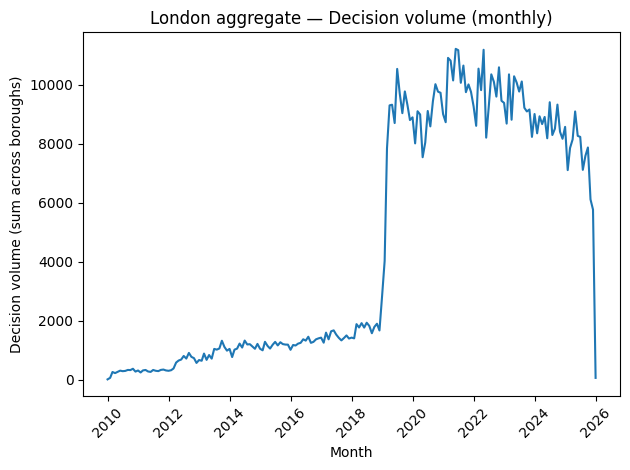

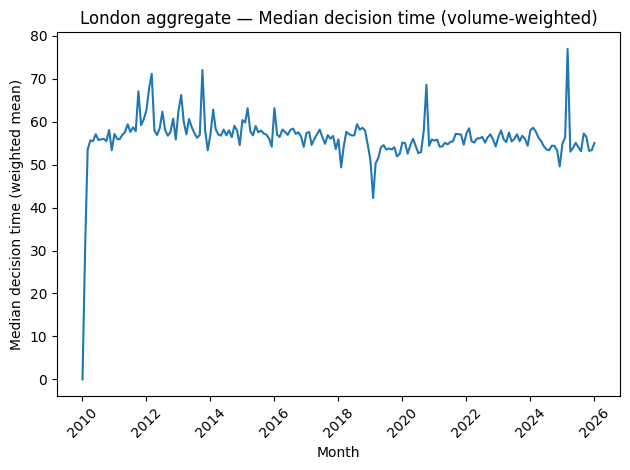

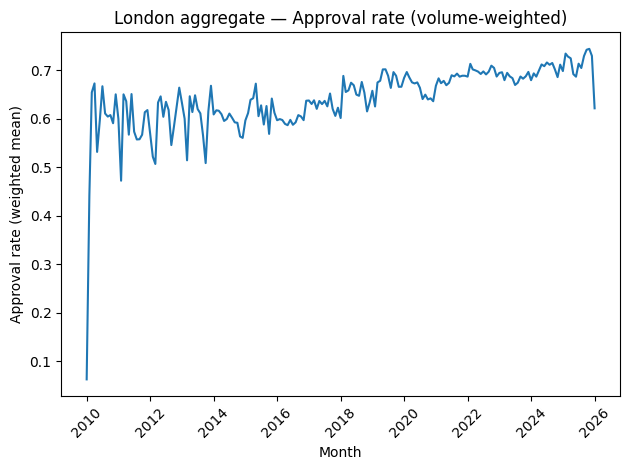

In [8]:
def weighted_mean(x, value_col, weight_col):
    w = x[weight_col].astype(float)
    v = x[value_col].astype(float)
    if w.sum() == 0:
        return np.nan
    return np.average(v, weights=w)

london = (
    df.groupby("year_month", as_index=False)
      .apply(lambda g: pd.Series({
          "london_volume": g[COL_VOL].sum(),
          "london_mdt": weighted_mean(g, COL_MDT, COL_VOL),
          "london_ar": weighted_mean(g, COL_AR,  COL_VOL),
      }))
      .reset_index(drop=True)
)

fig = plt.figure()
plt.plot(london["year_month"], london["london_volume"])
plt.title("London aggregate — Decision volume (monthly)")
plt.xlabel("Month")
plt.ylabel("Decision volume (sum across boroughs)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig = plt.figure()
plt.plot(london["year_month"], london["london_mdt"])
plt.title("London aggregate — Median decision time (volume-weighted)")
plt.xlabel("Month")
plt.ylabel("Median decision time (weighted mean)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig = plt.figure()
plt.plot(london["year_month"], london["london_ar"])
plt.title("London aggregate — Approval rate (volume-weighted)")
plt.xlabel("Month")
plt.ylabel("Approval rate (weighted mean)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

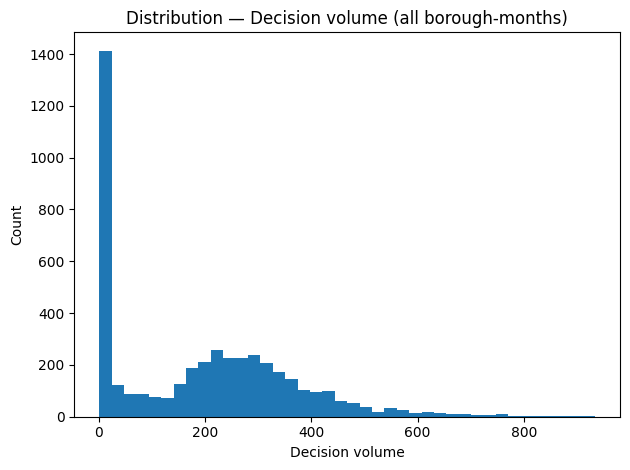

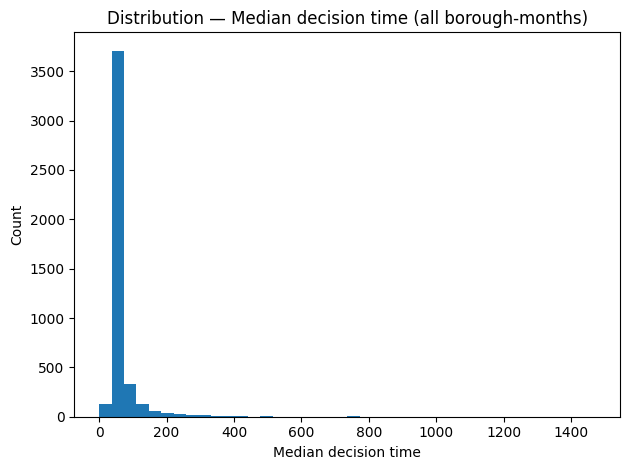

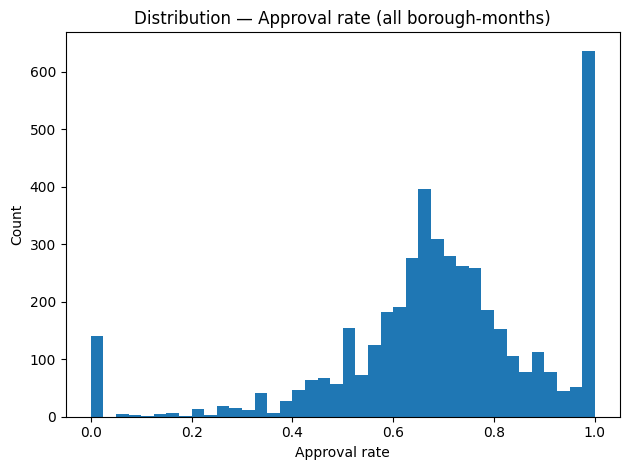

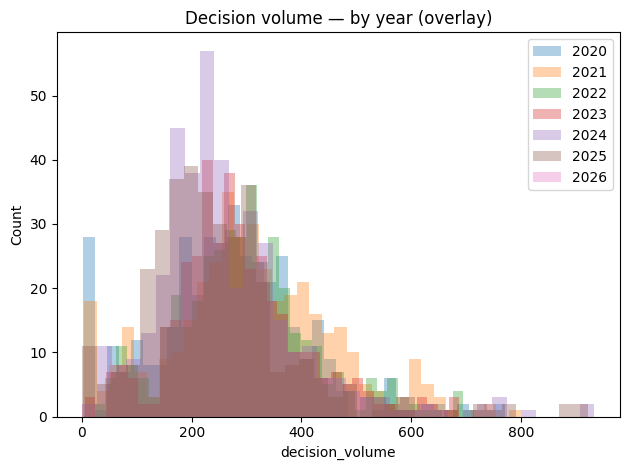

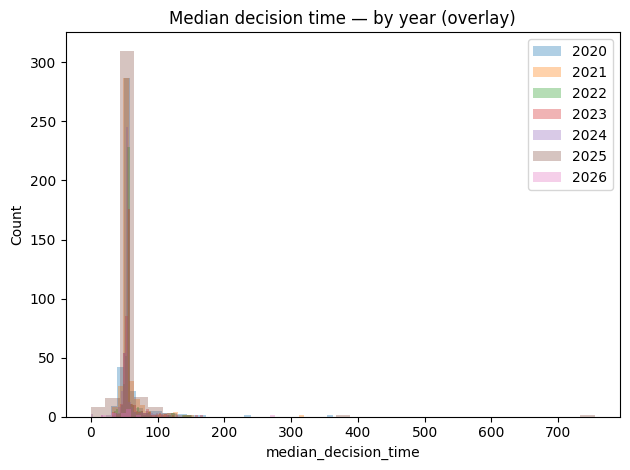

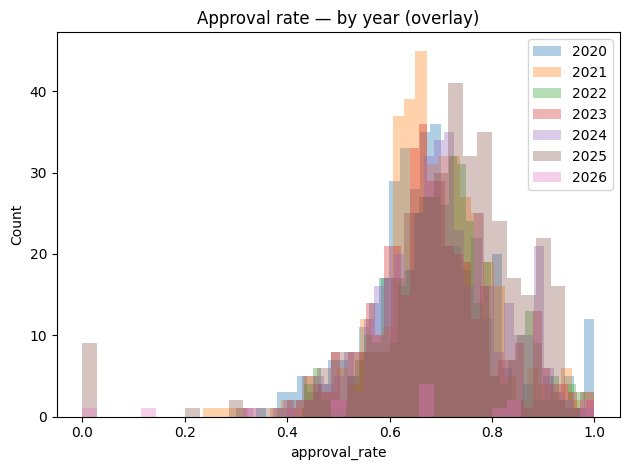

In [9]:
def hist_plot(series, title, xlabel, bins=40):
    fig = plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

hist_plot(df[COL_VOL], "Distribution — Decision volume (all borough-months)", "Decision volume")
hist_plot(df[COL_MDT], "Distribution — Median decision time (all borough-months)", "Median decision time")
hist_plot(df[COL_AR],  "Distribution — Approval rate (all borough-months)", "Approval rate")

# By-year distributions (small multiples would be ideal, but keep it simple: overlay per year)
def overlay_hist_by_year(d, col, title, bins=35, max_years=7):
    years = sorted(d["year"].dropna().unique())
    if len(years) > max_years:
        # keep recent years if too many
        years = years[-max_years:]

    fig = plt.figure()
    for y in years:
        s = d.loc[d["year"] == y, col].dropna()
        plt.hist(s, bins=bins, alpha=0.35, label=str(y))
    plt.title(title + " — by year (overlay)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

overlay_hist_by_year(df, COL_VOL, "Decision volume")
overlay_hist_by_year(df, COL_MDT, "Median decision time")
overlay_hist_by_year(df, COL_AR,  "Approval rate")

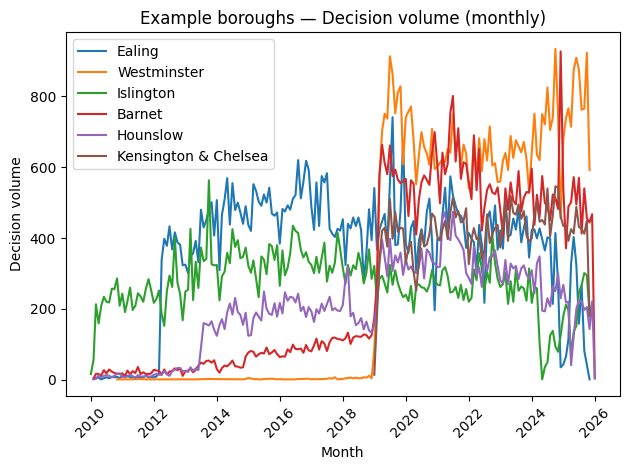

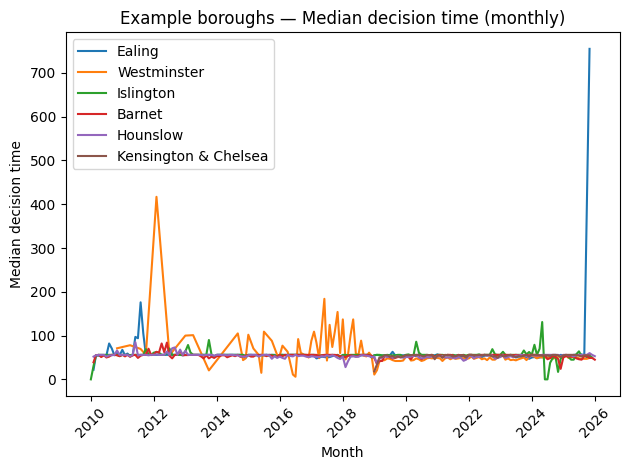

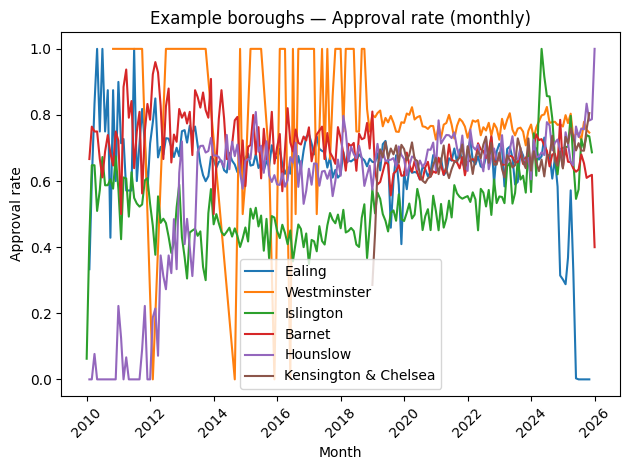

Example boroughs used: ['Ealing', 'Westminster', 'Islington', 'Barnet', 'Hounslow', 'Kensington & Chelsea']


In [10]:
top_boroughs = (
    df.groupby("lpa_name")[COL_VOL].sum()
      .sort_values(ascending=False)
      .head(6)
      .index.tolist()
)

# If you prefer manual examples, override like:
# top_boroughs = ["Camden", "Westminster", "Southwark", "Hackney", "Croydon", "Newham"]

df_ex = df[df["lpa_name"].isin(top_boroughs)].copy()

def plot_borough_lines(d, value_col, title, ylabel):
    fig = plt.figure()
    for b in top_boroughs:
        sub = d[d["lpa_name"] == b]
        plt.plot(sub["year_month"], sub[value_col], label=b)
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_borough_lines(df_ex, COL_VOL, "Example boroughs — Decision volume (monthly)", "Decision volume")
plot_borough_lines(df_ex, COL_MDT, "Example boroughs — Median decision time (monthly)", "Median decision time")
plot_borough_lines(df_ex, COL_AR,  "Example boroughs — Approval rate (monthly)", "Approval rate")

print("Example boroughs used:", top_boroughs)

C:\Users\Jose Miguel\AppData\Local\Temp\ipykernel_10680\4271353641.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


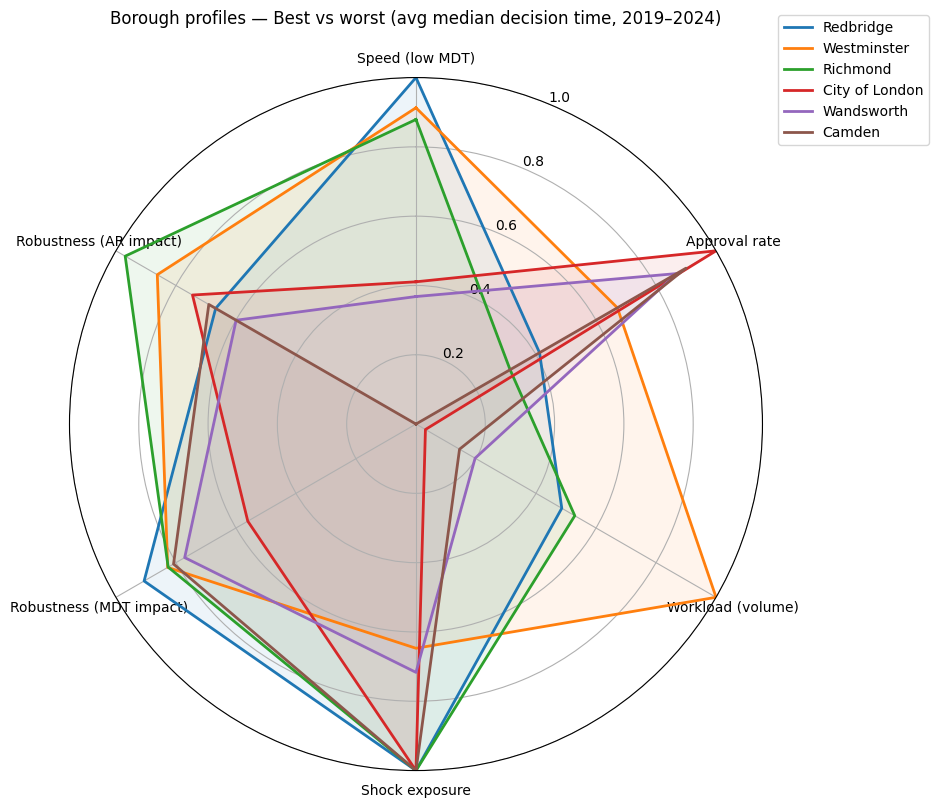

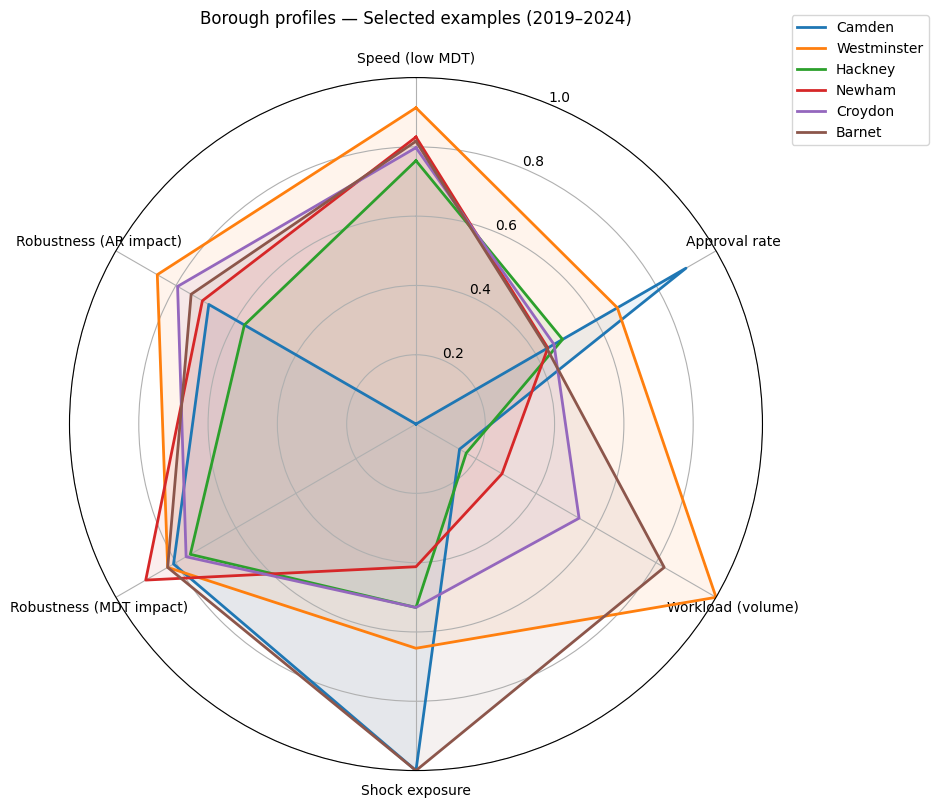

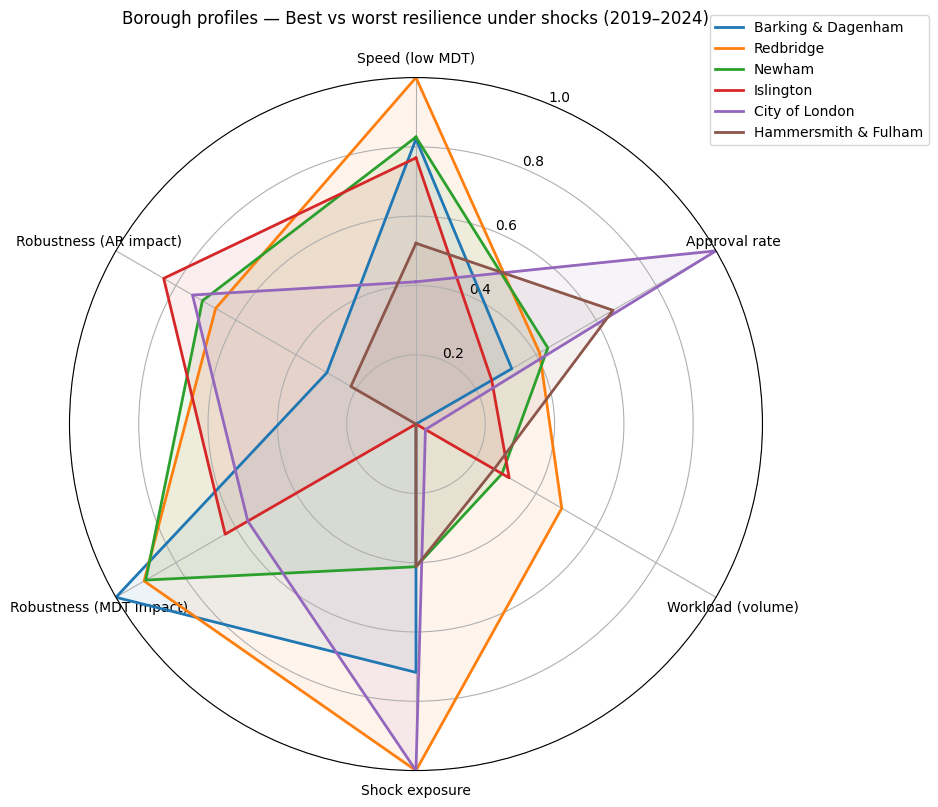

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load
# -----------------------------
df["year_month"] = pd.to_datetime(df["year_month"])

TRAIN_START = "2019-01-01"
TRAIN_END   = "2024-12-31"

train = df[(df["year_month"] >= TRAIN_START) & (df["year_month"] <= TRAIN_END)].copy()

# -----------------------------
# Build borough-level profile table
# -----------------------------
# Use shock_month if present; otherwise use shock_flag
shock_col = "shock_month" if "shock_month" in train.columns else "shock_flag"

profile = (
    train.groupby("lpa_name")
    .apply(lambda g: pd.Series({
        # Core performance
        "MDT_avg": g["median_decision_time"].mean(),
        "AR_avg":  g["approval_rate"].mean(),
        "VOL_avg": g["decision_volume"].mean(),

        # Shock exposure
        "Shock_rate": g[shock_col].astype(int).mean(),
        "Shock_intensity_avg": g.loc[g[shock_col].astype(bool), "shock_intensity"].mean()
            if (g[shock_col].astype(int).sum() > 0) else 0.0,

        # Deterioration during shocks (impacts)
        "Impact_MDT_shock_avg": g.loc[g[shock_col].astype(bool), "impact_mdt"].mean()
            if (g[shock_col].astype(int).sum() > 0) else 0.0,
        "Impact_AR_shock_avg": g.loc[g[shock_col].astype(bool), "impact_ar"].mean()
            if (g[shock_col].astype(int).sum() > 0) else 0.0,
    }))
    .reset_index()
)

# -----------------------------
# Choose radar dimensions
# IMPORTANT: higher should mean "better" for a clean radar.
# So we flip MDT and the impacts (because higher = worse).
# -----------------------------
dims = [
    "Speed (low MDT)",          # from MDT_avg (flipped)
    "Approval rate",            # AR_avg
    "Workload (volume)",        # VOL_avg
    "Shock exposure",           # Shock_rate
    "Robustness (MDT impact)",  # Impact_MDT_shock_avg (flipped)
    "Robustness (AR impact)",   # Impact_AR_shock_avg (flipped)
]

# Pull raw columns in same order:
raw_cols = [
    "MDT_avg",
    "AR_avg",
    "VOL_avg",
    "Shock_rate",
    "Impact_MDT_shock_avg",
    "Impact_AR_shock_avg",
]

# Convert to "higher = better" space
# - Speed: lower MDT better => invert
# - Robustness: lower impact better => invert
# AR and volume and shock_rate: depends on interpretation
#   Here: higher volume is "more workload" (not better or worse), but keep as "scale of activity"
#   Shock_rate: higher means more exposure; not "better" but still useful as a profile axis
#   If you want "less exposure is better", flip Shock_rate too.
profile_adj = profile.copy()
profile_adj["MDT_avg"] = -profile_adj["MDT_avg"]
profile_adj["Impact_MDT_shock_avg"] = -profile_adj["Impact_MDT_shock_avg"]
profile_adj["Impact_AR_shock_avg"]  = -profile_adj["Impact_AR_shock_avg"]

# OPTIONAL: if you want "less shock exposure is better", uncomment:
# profile_adj["Shock_rate"] = -profile_adj["Shock_rate"]

# -----------------------------
# Min-max scale to [0,1] per dimension
# -----------------------------
scaled = profile_adj.copy()
for c in raw_cols:
    mn, mx = scaled[c].min(), scaled[c].max()
    if np.isclose(mx - mn, 0):
        scaled[c] = 0.5
    else:
        scaled[c] = (scaled[c] - mn) / (mx - mn)

# -----------------------------
# Radar plotting helper
# -----------------------------
def radar_plot(df_scaled, boroughs, title):
    k = len(raw_cols)
    angles = np.linspace(0, 2*np.pi, k, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(9, 9))
    ax = plt.subplot(111, polar=True)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), dims)
    ax.set_ylim(0, 1)

    for b in boroughs:
        row = df_scaled[df_scaled["lpa_name"] == b]
        if row.empty:
            continue
        vals = row[raw_cols].values.flatten().tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=b)
        ax.fill(angles, vals, alpha=0.08)

    ax.set_title(title, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
    plt.show()

# -----------------------------
# Radar 1: Top vs Bottom by avg MDT (train)
# -----------------------------
tmp = profile.sort_values("MDT_avg", ascending=True)  # lower MDT = better
best3 = tmp["lpa_name"].head(3).tolist()
worst3 = tmp["lpa_name"].tail(3).tolist()
radar_plot(scaled, best3 + worst3, "Borough profiles — Best vs worst (avg median decision time, 2019–2024)")

# -----------------------------
# Radar 2: Your chosen boroughs (edit list)
# -----------------------------
example = ["Camden", "Westminster", "Hackney", "Newham", "Croydon", "Barnet"]
radar_plot(scaled, example, "Borough profiles — Selected examples (2019–2024)")

# -----------------------------
# Radar 3: “Resilience under shocks” — lowest deterioration during shock months
#   Here we rank by impact during shocks (lower is better).
# -----------------------------
res_rank = profile.sort_values(["Impact_MDT_shock_avg", "Impact_AR_shock_avg"], ascending=True)
best_shock3 = res_rank["lpa_name"].head(3).tolist()
worst_shock3 = res_rank["lpa_name"].tail(3).tolist()
radar_plot(scaled, best_shock3 + worst_shock3, "Borough profiles — Best vs worst resilience under shocks (2019–2024)")


C:\Users\Jose Miguel\AppData\Local\Temp\ipykernel_3324\1858623673.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\Jose Miguel\AppData\Local\Temp\ipykernel_3324\1858623673.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


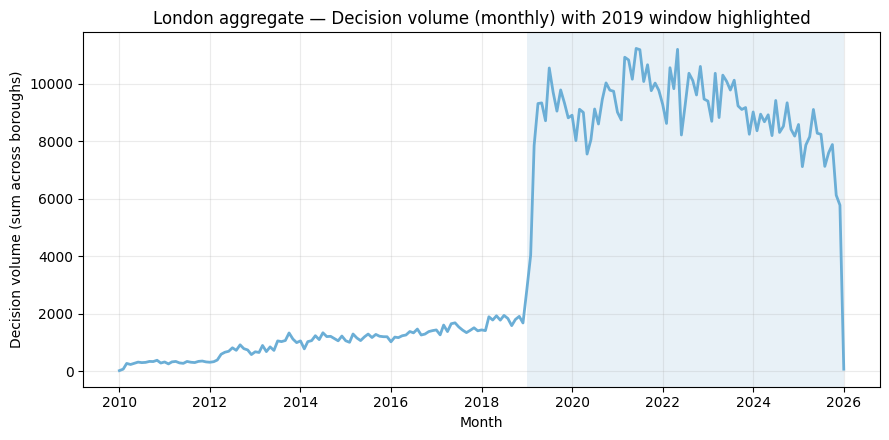

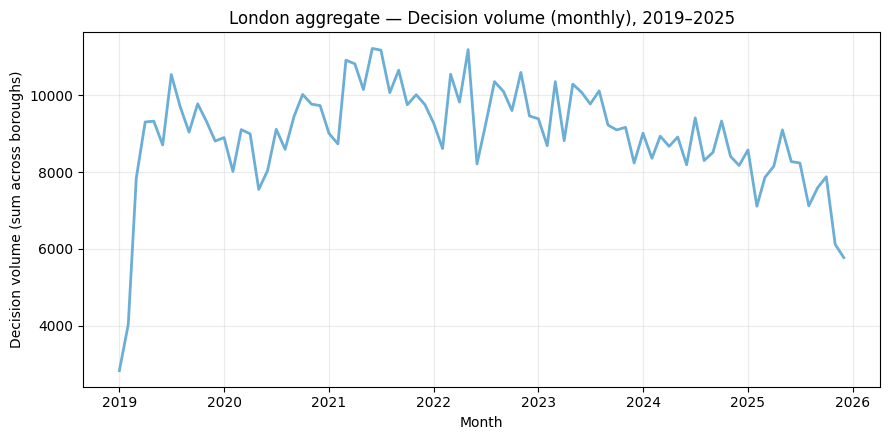

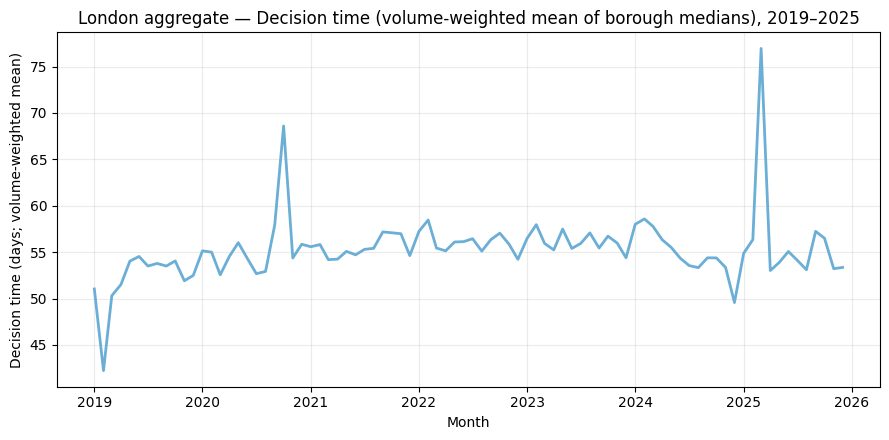

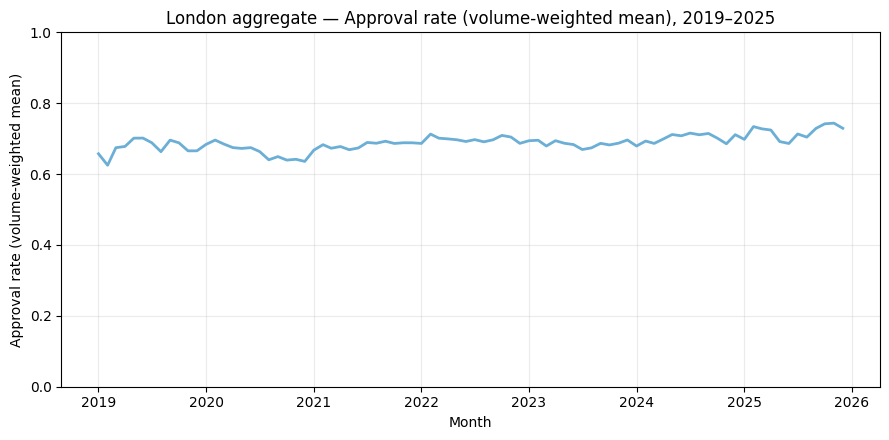

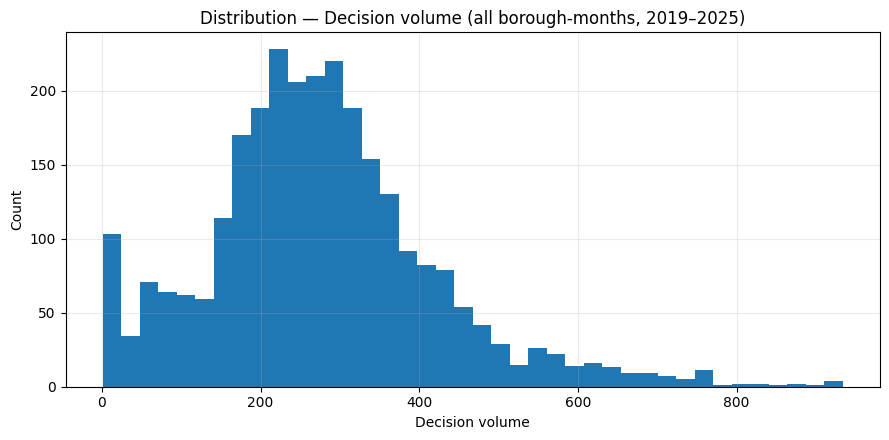

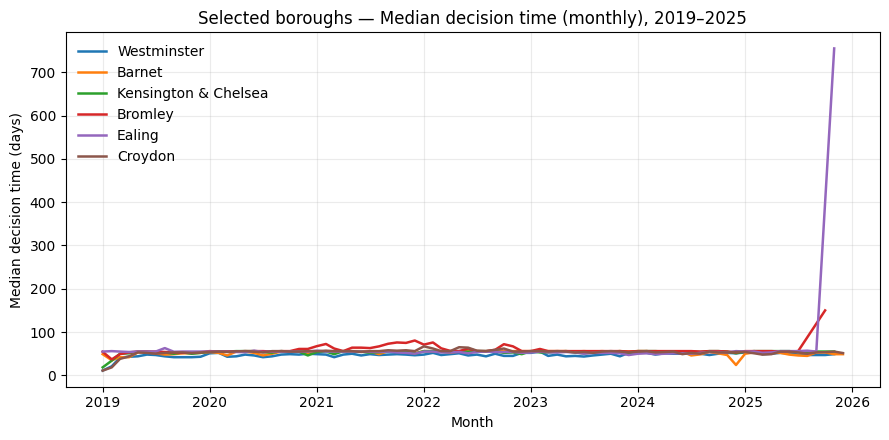

Selected boroughs used: ['Westminster', 'Barnet', 'Kensington & Chelsea', 'Bromley', 'Ealing', 'Croydon']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load + basic prep
# -----------------------------
df = pd.read_csv(r"C:\Users\Jose Miguel\OneDrive\Ambiente de Trabalho\NOVA\TESE\processed\borough_month_panel_resilience_inputs.csv")
df["year_month"] = pd.to_datetime(df["year_month"])
df["year"] = df["year_month"].dt.year

COL_VOL = "decision_volume"
COL_MDT = "median_decision_time"
COL_AR  = "approval_rate"

# hard filter to thesis scope for main figures
df_19_25 = df[(df["year_month"] >= "2019-01-01") & (df["year_month"] <= "2025-12-01")].copy()

def weighted_mean(g, value_col, weight_col):
    w = g[weight_col].astype(float).to_numpy()
    v = g[value_col].astype(float).to_numpy()
    s = np.nansum(w)
    if s == 0:
        return np.nan
    return np.average(v, weights=w)

def london_aggregate(d):
    out = (
        d.groupby("year_month", as_index=False)
         .apply(lambda g: pd.Series({
             "london_volume": g[COL_VOL].sum(),
             "london_mdt_wmean": weighted_mean(g, COL_MDT, COL_VOL),
             "london_ar_wmean":  weighted_mean(g, COL_AR,  COL_VOL),
         }))
         .reset_index(drop=True)
    )
    return out

london_full  = london_aggregate(df)       # for the one context plot if you want
london_19_25 = london_aggregate(df_19_25) # for thesis main plots

# -----------------------------
# Plot style (simple, consistent)
# -----------------------------
LINE_COLOR = "#6BAED6"   # light blue
GRID_ALPHA = 0.25

def base_axes(title, xlabel="Month"):
    fig = plt.figure(figsize=(9,4.5))
    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.grid(True, alpha=GRID_ALPHA)
    return fig, ax

def shade_scope(ax, start="2019-01-01", end="2025-12-31"):
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.10)

# -----------------------------
# (A) One context plot (optional): 2010–2025 volume + shade 2019–2025
# -----------------------------
fig, ax = base_axes("London aggregate — Decision volume (monthly) with 2019 window highlighted")
ax.plot(london_full["year_month"], london_full["london_volume"], linewidth=2, color=LINE_COLOR)
shade_scope(ax, "2019-01-01", "2025-12-31")
ax.set_ylabel("Decision volume (sum across boroughs)")
plt.tight_layout()
plt.show()

# -----------------------------
# (B) Thesis main plots: 2019–2025 only
# -----------------------------
fig, ax = base_axes("London aggregate — Decision volume (monthly), 2019–2025")
ax.plot(london_19_25["year_month"], london_19_25["london_volume"], linewidth=2, color=LINE_COLOR)
ax.set_ylabel("Decision volume (sum across boroughs)")
plt.tight_layout()
plt.show()

fig, ax = base_axes("London aggregate — Decision time (volume-weighted mean of borough medians), 2019–2025")
ax.plot(london_19_25["year_month"], london_19_25["london_mdt_wmean"], linewidth=2, color=LINE_COLOR)
ax.set_ylabel("Decision time (days; volume-weighted mean)")
plt.tight_layout()
plt.show()

fig, ax = base_axes("London aggregate — Approval rate (volume-weighted mean), 2019–2025")
ax.plot(london_19_25["year_month"], london_19_25["london_ar_wmean"], linewidth=2, color=LINE_COLOR)
ax.set_ylabel("Approval rate (volume-weighted mean)")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# -----------------------------
# (C) Distribution (keep ONLY volume histogram for Step 1)
# -----------------------------
fig, ax = base_axes("Distribution — Decision volume (all borough-months, 2019–2025)", xlabel="Decision volume")
ax.hist(df_19_25[COL_VOL].dropna(), bins=40, edgecolor="none")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# -----------------------------
# (D) Example boroughs (keep ONLY MDT)
# Choose top boroughs by total volume in 2019–2025 (or manually specify)
# -----------------------------
top_boroughs = (
    df_19_25.groupby("lpa_name")[COL_VOL].sum()
           .sort_values(ascending=False)
           .head(6)
           .index.tolist()
)

df_ex = df_19_25[df_19_25["lpa_name"].isin(top_boroughs)].copy()

fig, ax = base_axes("Selected boroughs — Median decision time (monthly), 2019–2025")
for b in top_boroughs:
    sub = df_ex[df_ex["lpa_name"] == b]
    ax.plot(sub["year_month"], sub[COL_MDT], linewidth=1.8, label=b)
ax.set_ylabel("Median decision time (days)")
ax.legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

print("Selected boroughs used:", top_boroughs)